# Analyzing the Value Premium

## Introduction
In 1992, Eugene Fama and Kenneth French introduced a Three-Factor Model that extends William Sharpe's CAPM with a Size Factor and a Value Factor:
<br><br>
$$
E(r) = \alpha + \beta_{1} *  (MKT-R_f) + \beta_{2} * SMB + \beta_{3} * HML
$$
<br>
Given the parsimonous structure, the theoretical existence of state variables that investors want to hedge against and the poor performance of the CAPM, it has become, together with Fama/French's (FF) extended 5-Factor Model, the standard model to price the cross-section of equity returns.
<br>
However, since the publication of the paper, both factors failed to deliver any premium out-of-sample and the value premium (HML) in particular currently experiences a 20-year long drawdown, erasing half of its entire 100-year cumulative outperformance. Sceptics claim that both premia are unrelated to risk and that the model is a result of data snooping. Once the existence of a new factor becomes common knowledge and investors adapt and try to exploit it, it should, via arbitrage, ultimately vanish. 
<br>
While asset pricing theory points to factors aside from the sensitivity to the market portfolio and although the four additional Fama/French factors are theoretically sound as they directly relate to the pricing equation, it is unclear whether they can indeed proxy the underlying risk factors. This notebook puts aside the theory and provides a quantitative analysis of the drivers of the value premium and shows that it cannot be concluded that the value premium vanished.

**Data sources:**
* Kenneth French's Academic Portfolios (https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
  * In particular *Fama/French 5 Factors* and *6 Portfolios Formed on Size and Book-to-Market (2 x 3)*
* Robert Shiller's History of Bond Rates (http://www.econ.yale.edu/~shiller/data.htm)

#### Importing the Data

In [364]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm
from finance_data import FrenchReader, ShillerReader

In [281]:
plt.style.use("seaborn-bright")
plt.rcParams["figure.figsize"] = (12,6)

In [282]:
bond_rate = ShillerReader.cape()["10-Year Interest Rate"] / 100
ff3 = FrenchReader("F-F_Research_Data_Factors").read()["Main"] / 100
ff5 = FrenchReader("F-F_Research_Data_5_Factors_2x3").read()["Main"] / 100
mom = FrenchReader("F-F_Momentum_Factor").read()["Main"] / 100
df = pd.concat([ff3, mom, bond_rate], axis=1).dropna()
df["RMW"] = ff5["RMW"]
df["CMA"] = ff5["CMA"]
df = df[["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom", "RF", "10-Year Interest Rate"]]
df

,Mkt-RF,SMB,HML,RMW,CMA,Mom,RF,10-Year Interest Rate
1927-01-01,-0.0006,-0.0051,0.0473,NaN,NaN,0.0036,0.0025,0.033400
1927-02-01,0.0418,-0.0025,0.0327,NaN,NaN,-0.0214,0.0026,0.033392
1927-03-01,0.0013,-0.0189,-0.0256,NaN,NaN,0.0361,0.0030,0.033383
1927-04-01,0.0046,0.0049,0.0071,NaN,NaN,0.0430,0.0025,0.033375
1927-05-01,0.0544,0.0146,0.0498,NaN,NaN,0.0300,0.0030,0.033367
...,...,...,...,...,...,...,...,...
2021-08-01,0.0290,-0.0048,-0.0013,-0.0026,-0.0167,0.0252,0.0000,0.012800
2021-09-01,-0.0437,0.0080,0.0509,-0.0194,0.0208,0.0157,0.0000,0.013700
2021-10-01,0.0665,-0.0228,-0.0044,0.0174,-0.0148,0.0321,0.0000,0.015800
2021-11-01,-0.0155,-0.0135,-0.0053,0.0738,0.0160,0.0082,0.0000,0.015600


In [283]:
portfolio_data = FrenchReader("6_Portfolios_2x3").read()
for key in portfolio_data.keys():
    print(key)

Average Value Weighted Returns Monthly
Average Equal Weighted Returns Monthly
Average Value Weighted Returns Annual
Average Equal Weighted Returns Annual
Number of Firms in Portfolios
Average Market Cap
Value Weight Average of BE/ME
Value Weight Average of BE_FYt-1/ME_June
Value Weight Average of OP
Value Weight Average of investment


## Analysis

Since 2004, the value premium had its largest drawdown in history and shed about half of its cumulative outperformance since 1927.

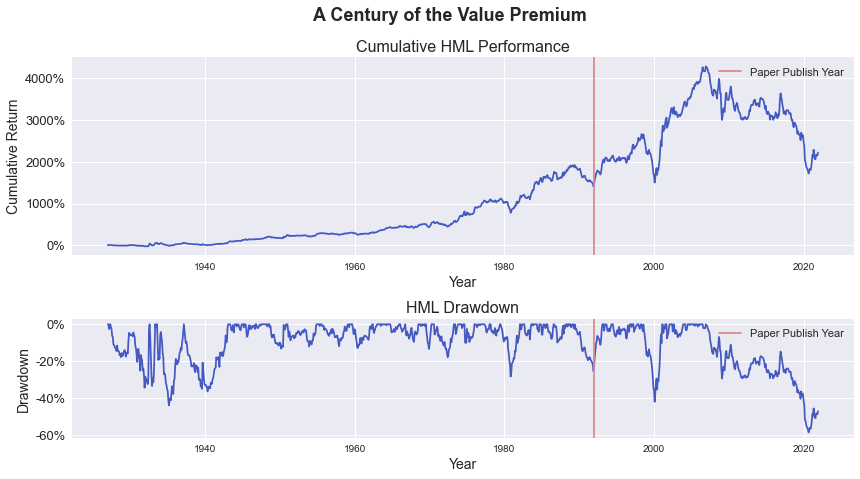

In [310]:
df["HML cumulative"] = (1+df["HML"]).cumprod()
df["HML drawdown"] = df["HML cumulative"] / df["HML cumulative"].cummax() - 1

figure, axes = plt.subplots(2, gridspec_kw={'height_ratios': [5, 3]}, figsize=(14,7))
plt.subplots_adjust(hspace=0.4)
figure.suptitle("A Century of the Value Premium", fontsize=18, fontweight="bold")

axes[0].set_title("Cumulative HML Performance", size=16)
axes[0].set_xlabel("Year", size=14)
yticks = np.linspace(0, (df["HML cumulative"]-1).max() // 10 * 10, 5)
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[0].set_ylabel("Cumulative Return", size=14)
axes[0].plot(df["HML cumulative"]-1, color="#4459c2")
axes[0].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#db8a8a")
axes[0].legend(fontsize=11, loc="upper right");

axes[1].set_title("HML Drawdown", size=16)
axes[1].set_xlabel("Year", size=14)
yticks = [-0.6,-0.4,-0.2, 0]
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].plot(df["HML drawdown"], color="#4459c2")
axes[1].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#db8a8a")
axes[1].legend(fontsize=11, loc="upper right");

Neither factor of Fama/French's five-factor model, except for the equity premium itself, has delivered a significant premium since the publication of the respective model in 1992 and 2015, which questions out-of-sample performance of the model to price equity risk.
<br>
*(although 2015 to today is a too small sample to conclude anything)*

In [343]:
print("Since 1992,...")
for factor in ("Mkt-RF", "SMB", "HML"):   
    ols_fit = OLS(df.loc["1992-01-01":, factor], [1 for _ in range(len(df.loc["1992-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")
print("")
print("Since 2015,...")
for factor in ("RMW", "CMA"):   
    ols_fit = OLS(df.loc["2015-01-01":, factor], [1 for _ in range(len(df.loc["2015-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")

Since 1992,...
...the Mkt-RF factor returned an average of 0.76% per month with a t-statistic of 3.35.
...the SMB factor returned an average of 0.14% per month with a t-statistic of 0.80.
...the HML factor returned an average of 0.17% per month with a t-statistic of 1.02.

Since 2015,...
...the RMW factor returned an average of 0.36% per month with a t-statistic of 1.66.
...the CMA factor returned an average of -0.15% per month with a t-statistic of -0.75.


With all four factors failing out-of-sample, the question arises whether the factors can deliver any premium going forward.
Aside from the nature of the model itself, there are 3 arguments that, considered individually or together, can invalidate the claim that the recent data points to an arbitraged away value premium:
<br>
1. It can simply be the result of chance.
2. The underperformance is explained by changing investors' taste towards growth stocks
3. Macroeconomic shifts affected value and growth stocks differently

**1. The underperformance is the result of chance**
<br>
Given that all factors carry a sizable amount of risk in the form of volatility, it should be of no surprise that a factor with positive mean can underperform for a lengthy period. For example, for an iid white noise process with a yearly mean return of 10% and 20% yearly volatility, there is still a probability of >2% that the process realizes an average return <0 over a period of 20 years. Likewise, the US market portfolio showed multiple periods of 20 year underperformance against bonds.

In [369]:
prior_mean = df.loc[:"1992-01-01", "HML"].mean()
prior_std = df.loc[:"1992-01-01", "HML"].std()
post_mean = df.loc["1992-01-01":, "HML"].mean()
post_std = df.loc["1992-01-01":, "HML"].std()
prior_post_diff = prior_mean - post_mean
post_sample_size = df.loc["1992-01-01":, "HML"].count()
post_std_err = post_std / np.sqrt(post_sample_size)
sigma = prior_post_diff / post_std_err
p_value = 1 - norm.cdf(sigma)
print(
f"""
Prior to publication in 1992, the value premium delivered a monthly premium of {prior_mean:.2%} with a volatility of {prior_std:.2%}.
Post publication, the average premium was {post_mean:.2%} per month, hence {prior_post_diff:.2%} lower.
However, incorporating the monthly volatility of {post_std:.2%} and the post publication sample size of {post_sample_size} months, 
the standard error of the post publication mean is {post_std_err:.2%}.
The difference between the prior publication mean and post publication mean thus lies within {sigma:.2f} standard deviations or within the probability of {p_value:.2%}.
Put together, the mere observation of the poor post-publication performance could well be the result of chance.
"""
)


Prior to publication in 1992, the value premium delivered a monthly premium of 0.42% with a volatility of 3.68%.
Post publication, the average premium was 0.17% per month, hence 0.25% lower.
However, incorporating the monthly volatility of 3.20% and the post publication sample size of 360 months, 
the standard error of the post publication mean is 0.17%.
The difference between the prior publication mean and post publication mean thus lies within 1.46 standard deviations or within the probability of 7.24%.
Put together, the mere observation of the poor post-publication performance could well be the result of chance.



**2. The underperformance is explained by changing investors' taste**
<br>

**3. Macroeconomic shifts affected value and growth stocks differently**
<br>